In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

### Data set:
https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope

In [51]:
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
df = pd.read_csv("magic_gamma_telescope/magic04.data", names=cols)
df.head()
type(df)

pandas.core.frame.DataFrame

In [52]:
df["class"] = (df["class"] == "g").astype(int)

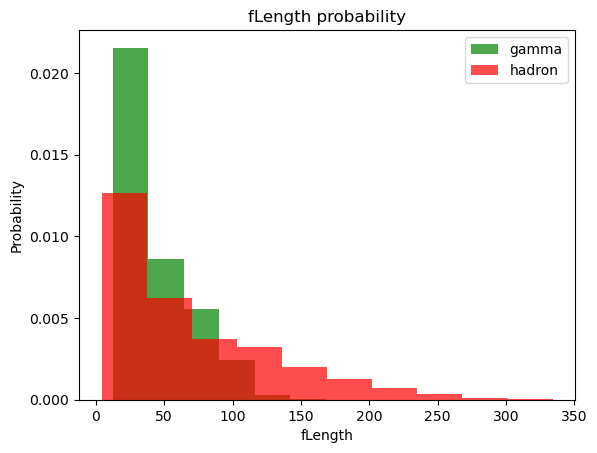

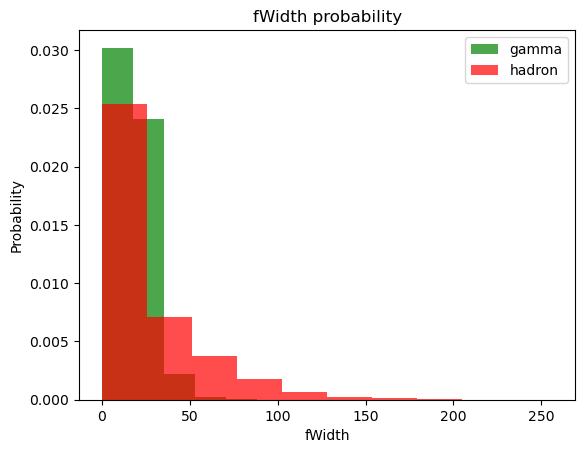

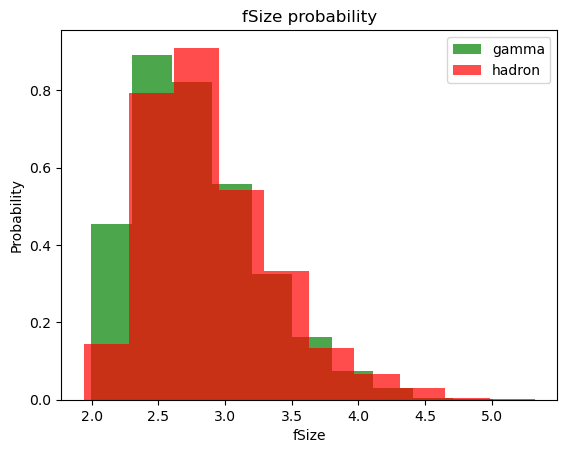

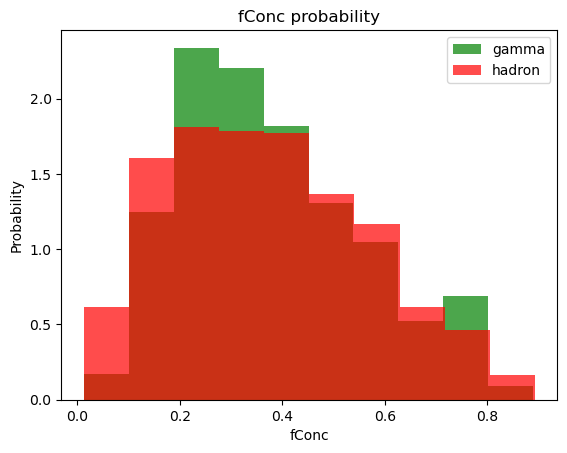

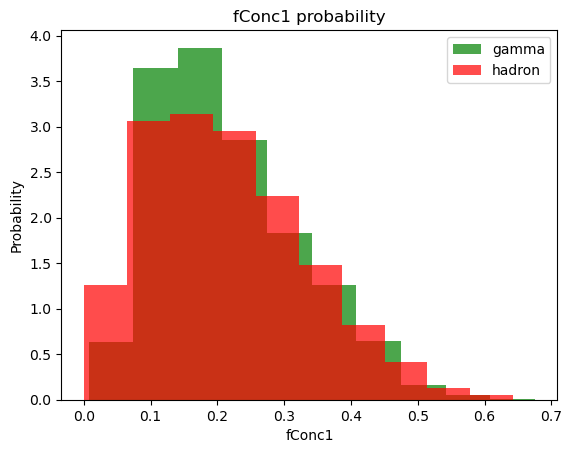

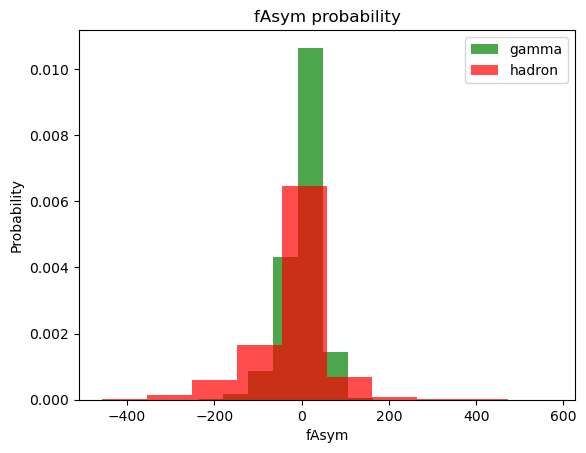

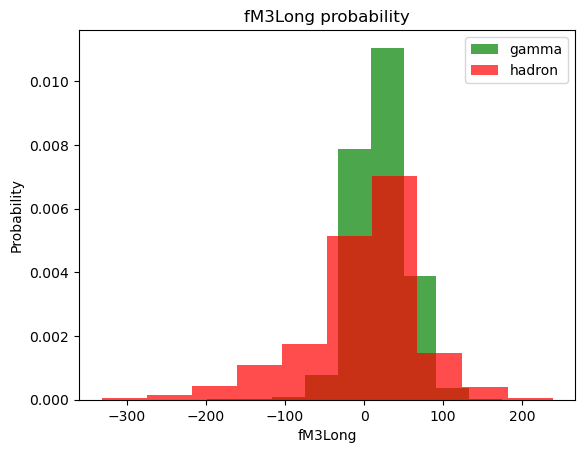

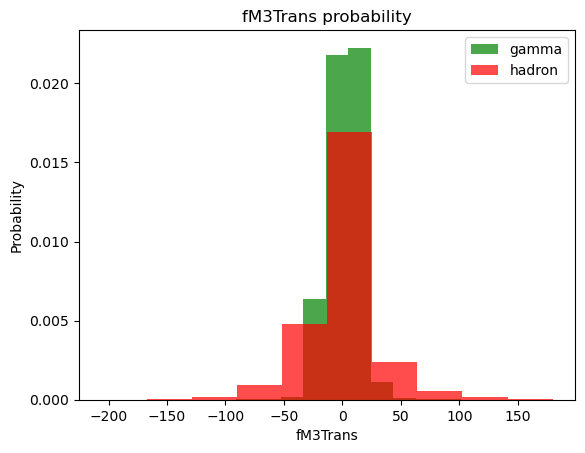

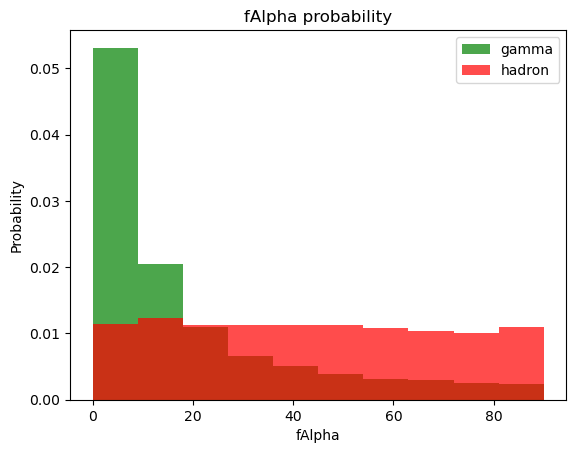

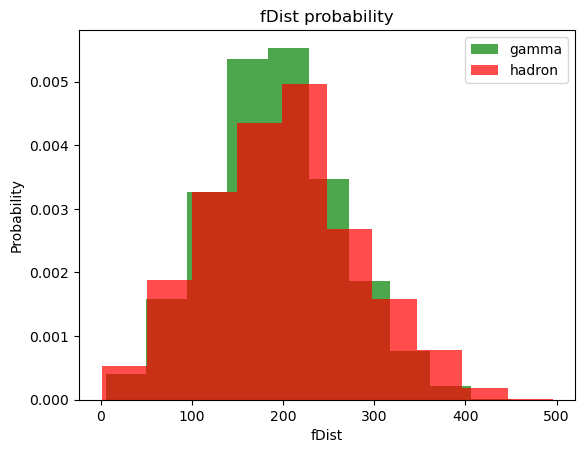

In [53]:
for col in cols[:-1]:
    plt.hist(df[df["class"] == 1][col], color= "green", alpha=0.7, density=True, label= "gamma", bins= 10)
    plt.hist(df[df["class"] == 0][col], color= "red", alpha=0.7, density=True, label= "hadron", bins= 10)
    plt.title(col + " probability")
    plt.ylabel("Probability")
    plt.xlabel(col)
    plt.legend()
    plt.show()

# data splitting

In [54]:
train_split, valid_split, test_split = np.split(df.sample(frac=1), indices_or_sections=[int(0.6 * len(df)), int(0.8 * len(df))])

In [55]:
"""
Normalises the values of the features AFAIK and oversamples if required
"""
def scale_dataset(dataframe: pd.DataFrame, shouldOversample: bool = False):
    X = dataframe[dataframe.columns[:-1]].values # X is caps, by convention in ML, since it is a 2-D matrix and this differentiates it from the 1-D array `y`
    y = dataframe[dataframe.columns[-1]].values

    X = StandardScaler().fit_transform(X)
    
    if shouldOversample:
        X, y = oversample(X, y)
    data = np.hstack([X, np.reshape(y, (-1, 1))])

    return data, X, y

def oversample(X, y):
    return RandomOverSampler().fit_resample(X, y)


In [56]:
train, X_train, y_train = scale_dataset(train_split, shouldOversample = True)
valid, X_valid, y_valid = scale_dataset(valid_split, shouldOversample = False)
test, X_test, y_test = scale_dataset(test_split, shouldOversample = False)
print(train)
print(X_train)

[[ 1.17817757e+00  4.34803216e-01  1.63320003e+00 ... -9.82341435e-01
   1.35639099e+00  1.00000000e+00]
 [-7.94554050e-01 -7.01487557e-01 -5.27504517e-01 ... -3.04910233e-01
  -9.35094578e-03  0.00000000e+00]
 [-4.84090276e-01 -8.23037635e-01 -7.97937797e-01 ...  2.27957545e+00
  -9.30653862e-01  0.00000000e+00]
 ...
 [-4.17853371e-01 -3.64791537e-01 -9.32817183e-02 ...  7.57363959e-01
   6.66411284e-01  0.00000000e+00]
 [ 3.03946079e+00  4.25068230e+00  2.83219879e+00 ...  1.58728439e+00
   1.44847739e+00  0.00000000e+00]
 [-5.63933950e-01 -1.92347782e-01  1.25308871e-03 ...  5.44912961e-01
   3.34703817e-02  0.00000000e+00]]
[[ 1.17817757e+00  4.34803216e-01  1.63320003e+00 ...  9.35947146e-01
  -9.82341435e-01  1.35639099e+00]
 [-7.94554050e-01 -7.01487557e-01 -5.27504517e-01 ... -2.60891812e-01
  -3.04910233e-01 -9.35094578e-03]
 [-4.84090276e-01 -8.23037635e-01 -7.97937797e-01 ...  2.91321073e-01
   2.27957545e+00 -9.30653862e-01]
 ...
 [-4.17853371e-01 -3.64791537e-01 -9.3281718

# kNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [58]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, y_train)
y_pred_kNN = knn_model.predict(X_test)
print(classification_report(y_true = y_test, y_pred = y_pred_kNN))


              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1318
           1       0.85      0.86      0.86      2486

    accuracy                           0.81      3804
   macro avg       0.79      0.79      0.79      3804
weighted avg       0.81      0.81      0.81      3804



### Illustration of accuracy measurement
|              |  actual 0  |  actual 1  |
|--------------|------------|------------|
|  predicted 0 |      a     |      b     |
|  predicted 1 |      c     |      d     |

precision - how many of the items of a class are correctly predicted w.r.t. all the items predicted to be of that class.<br>
&emsp;&emsp;&emsp;&emsp;precision(class0) = a / (a + b)

recall    - how many of the items of a class are correctly predicted w.r.t. all the items actually of that class in reality.<br>
&emsp;&emsp;&emsp;&emsp;recall(class0) = a / (a + c)

### Bayes probability example
|  no of balls |   rough    |   smooth   |
|--------------|------------|------------|
|      red     |      a     |      b     |
|      blue    |      c     |      d     |

a, b, c, d are the number of balls with the specified classes<br>
probability that a ball is red, given it is rough -> $ P(red | rough) = \dfrac{P(rough | red) \times P(red)}{P(rough)}$<br>
which I guess can be derived from this:<br>
$ P(rough | red) \times P(red) = \dfrac{a}{(a + b)} \times \dfrac{(a + b)}{(a + b + c + d)} = \dfrac{a}{(a + b + c + d)}$<br>
$ P(red | rough) \times P(rough) = \dfrac{a}{(a + c)} \times \dfrac{(a + c)}{(a + b + c + d)} = \dfrac{a}{(a + b + c + d)}$

# Naive bayes

Here we have a classification problem. $C_k$ represents class k. $X_1, X_2, ...$ represents the feature vector.<br>
Therefore the probability of the class being $C_k$ given the feature vector $X_1, X_2, ..., X_n$ can be denoted as $P(C_k| X_1, X_2, ..., X_n)$<br>
$P(C_k| X_1, X_2, ..., X_n) = \dfrac{P(X_1, X_2, ..., X_n | C_k) \times P(C_k)}{P(X_1, X_2, ..., X_n)}$<br>
$P(X_1, X_2, ..., X_n)$ is independent of the class, so for a given feature vector(while computing probability of a class), it would be constant.<br>
Assuming that the features are independent, $P(X_1, X_2, ..., X_n | C_k)$ can be written as $P(P(X_1 | C_k)) \times P(P(X_2 | C_k)) \times ... \times P(P(X_n | C_k))$<br>
$\implies P(C_k| X_1, X_2, ..., X_n) \propto P(C_k) \prod_{i = 1}^{n}P(X_i | C_k)$<br>

So, the predicted class given a feature vector would be:<br>
$$\argmax_{k \in \{1, k\}}\left(P(C_k) \prod_{i = 1}^{n}P(X_i | C_k)\right)$$

Basically, find the max of $P(C_k) \prod_{i = 1}^{n}P(X_i | C_k)$ of all classes, and we have the predicted class

In [59]:
from sklearn.naive_bayes import GaussianNB

In [60]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [61]:
y_pred_NB = nb_model.predict(X_test)
print(classification_report(y_true = y_test, y_pred= y_pred_NB))

              precision    recall  f1-score   support

           0       0.70      0.41      0.51      1318
           1       0.74      0.91      0.82      2486

    accuracy                           0.73      3804
   macro avg       0.72      0.66      0.67      3804
weighted avg       0.73      0.73      0.71      3804



# Logistic regression

Good explanation of coming up with a model on how we get to a sigmoid function starting with linear regression with the constraints of probability on https://youtu.be/i_LwzRVP7bg?t=4839

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
lr2_model = LogisticRegression(penalty = "l2")
lr2_model.fit(X_train, y_train)
y_pred_lr2 = lr2_model.predict(X_test)
print(classification_report(y_true = y_test, y_pred = y_pred_lr2))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1318
           1       0.85      0.82      0.83      2486

    accuracy                           0.79      3804
   macro avg       0.76      0.77      0.77      3804
weighted avg       0.79      0.79      0.79      3804



# Support vector machines

In [64]:
from sklearn.svm import SVC

In [65]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)

print(classification_report(y_true = y_test, y_pred = y_pred_svc))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1318
           1       0.89      0.90      0.89      2486

    accuracy                           0.86      3804
   macro avg       0.85      0.84      0.85      3804
weighted avg       0.86      0.86      0.86      3804



# Neural network


A neuron would take the feature vector, with each feature multiplied by some weight and add a bias, which is then passed into an activation function.<br>
The activation functions are generally not straight up linear or polynomials, since such functions would result in the neural net being expressed as a trivial expression.<br>
There is some math behind why activation function is usually one of sigmoid ($\dfrac{1}{1 + e^{-x}}$), tanh or ReLU(rectified linear unit)

#### Backpropogation:<br>
Backpropogation in my understanding are tools to train the model (i.e. adjusting weights)

Gradient descent: $w_{0, new} = w_{0, old} + \alpha \times \left(\dfrac{\mathrm{d}loss}{\mathrm{d} w_{0, old}}\right)$<br>
$\alpha$ is the learning rate<br>
The idea is to adjust weights with a rate that is proportional to the gradient of loss w.r.t. the weigth. i.e. With higher loss, we change the weights to a greater extent<br>

## Tensorflow

##### Some terminology:
 - *Sequential TF API* : simple, all layers in sequence
 - *Functional TF API* : more advanced, complex models
 - *Dense* : all nodes in a layer are connected to all nodes on the next layer

In [75]:
import tensorflow as tf

In [107]:
def plot_loss(history: tf.keras.callbacks.History, ax: plt.Axes = None):
    show_plot = False
    if ax == None:
        _, ax = plt.subplots()
        show_plot = True
    ax.plot(history.history['loss'], label = 'loss')
    ax.plot(history.history['val_loss'], label = 'val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Binary crossentropy')
    ax.legend()
    ax.grid(True)
    if show_plot:
        plt.show()

def plot_accuracy(history: tf.keras.callbacks.History, ax: plt.Axes):
    show_plot = False
    if ax == None:
        _, ax = plt.subplots()
        show_plot = True
    ax.plot(history.history['accuracy'], label = 'accuracy')
    ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)
    if show_plot:
        plt.show()

def plot_loss_accuracy(history: tf.keras.callbacks.History, title: str):
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
    plot_loss(history = history, ax = ax1)
    plot_accuracy(history = history, ax = ax2)
    plt.title(title)
    plt.show()

In [110]:
# `validation_split` will take a split of data from the training data, while `validation_data`(which if is not None,
#   will ignore `validation_split`) can be a tuple, which contains validation data separate from the training data
def get_nn_model_history(X_train, y_train, num_nodes: int, dropout_probability, learning_rate, batch_size, epochs: int, validation_split = None, validation_data = None):
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation = 'relu', input_shape = (len(cols[:-1]),)),
        tf.keras.layers.Dropout(dropout_probability),
        tf.keras.layers.Dense(num_nodes, activation = 'relu'),
        tf.keras.layers.Dropout(dropout_probability),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate), 
                    loss = 'binary_crossentropy',
                    metrics = [
                        'accuracy'
                    ])
    def fit():
        return nn_model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = validation_split, validation_data = validation_data, verbose = 0)
    
    return nn_model, fit()

### Testing different hyperparameters

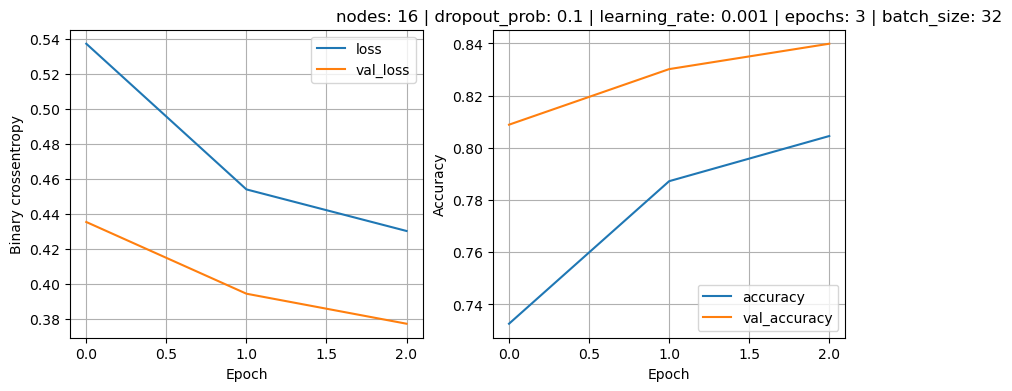

119/119 [==============================] - 0s 554us/step - loss: 0.3835 - accuracy: 0.8304


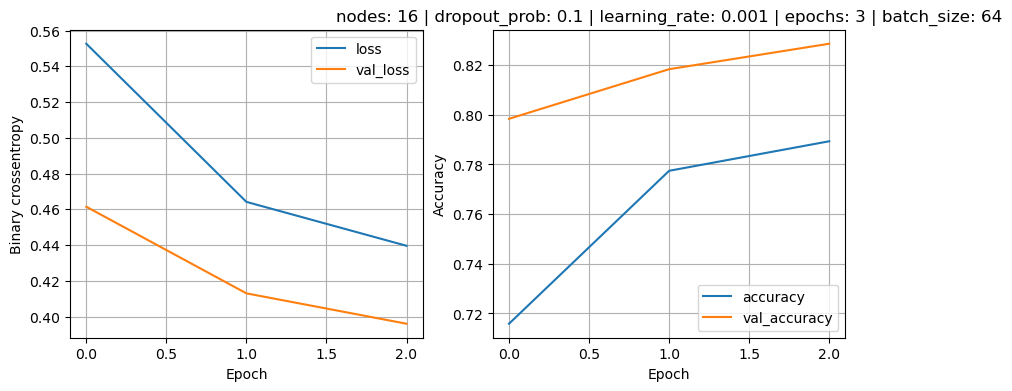

119/119 [==============================] - 0s 559us/step - loss: 0.3971 - accuracy: 0.8331


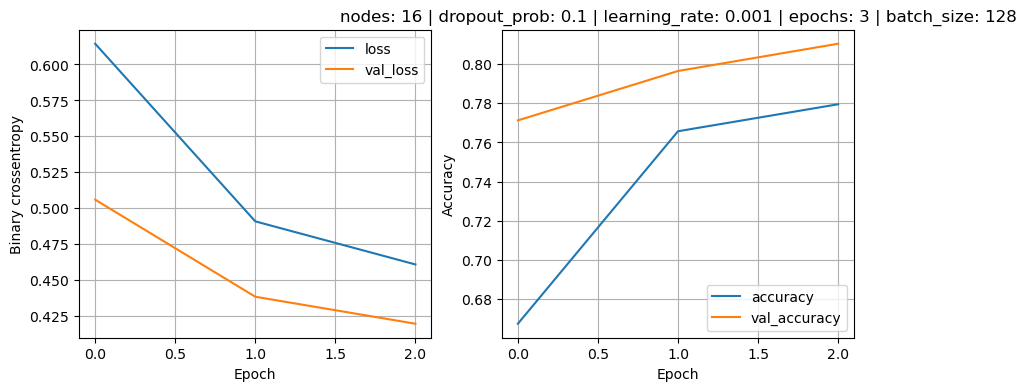

119/119 [==============================] - 0s 540us/step - loss: 0.4202 - accuracy: 0.8034
(3, 16, 0.1, 0.001, 32)


In [118]:
epochs_list = [100]
num_nodes_list = [16, 32, 64]
dropout_prob_list = [0, 0.1, 0.2, 0.3]
learning_rate_list = [0.001, 0.005, 0.1]
batch_size_list = [32, 64, 128]

# epochs_list = [3]
# num_nodes_list = [16]
# dropout_prob_list = [0.1]
# learning_rate_list = [0.001]
# batch_size_list = [32, 64, 128]

permutations = [[i, j, k, l, m] for i in epochs_list
                for j in num_nodes_list
                for k in dropout_prob_list
                for l in learning_rate_list
                for m in batch_size_list]
val_loss = {}

for permutation in permutations:
    [epochs, num_nodes, dropout_prob, learning_rate, batch_size] = permutation
    nn_model: tf.keras.Model; nn_model_history: tf.keras.callbacks.History;
    nn_model, nn_model_history = get_nn_model_history(X_train, y_train, num_nodes = num_nodes, dropout_probability = dropout_prob, learning_rate = learning_rate, epochs = epochs, batch_size = batch_size, validation_data= (X_valid, y_valid))
    plot_loss_accuracy(history = nn_model_history, title = f"nodes: {num_nodes} | dropout_prob: {dropout_prob} | learning_rate: {learning_rate} | epochs: {epochs} | batch_size: {batch_size}")
    val_loss[(epochs, num_nodes, dropout_prob, learning_rate, batch_size)] = (nn_model, nn_model.evaluate(X_test, y_test))

min_loss = float('inf')
min_loss_permuatation = None
min_loss_model = None
for key, (model, model_evaluation) in val_loss.items(): # val ===> [loss, accuracy]
    if model_evaluation[0] < min_loss:
        min_loss = model_evaluation[0]
        min_loss_permuatation = key
        min_loss_model = model

print(min_loss_permuatation)